<a href="https://colab.research.google.com/github/mikemehallow/fun-data-science-projects/blob/master/Resnet_18_for_MNIST_Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install transformers
from transformers import ViTModel
import torch.nn as nn

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)

from PIL import Image
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

import tensorflow as tf
import time
from sklearn.metrics import confusion_matrix


mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

In [15]:
# path_data = Path('data')
# path_gz = path_data/'mnist.pkl.gz'
# with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

x_train = x_train[:, None,:,:].float()
x_valid = x_valid[:, None,:,:].float()

In [56]:
# 2. Create a DataLoader for your training data
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=32*2*2*2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32*2*2*2, shuffle=True)

In [201]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [202]:
# Modify the first convolutional layer to accept 1 input channel (for grayscale images)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

num_classes = 10  # Replace with your number of classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),  # First fully connected layer (512 output features - adjust as needed)
    nn.ReLU(),                    # Activation function (ReLU is common)
    nn.Dropout(0.2),              # Optional dropout for regularization
    nn.Linear(256, num_classes)   # Second fully connected layer (num_classes is your number of output classes)
)

In [218]:

# 4. Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = True

# Unfreeze the last fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

In [219]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [220]:
# 5. Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  # Only optimize the unfrozen parameters

# 6. Training loop
num_epochs = 20  # Adjust as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device) # Move model to the selected device

total_steps = len(train_loader) * num_epochs  # Total number of training steps
scheduler = OneCycleLR(optimizer, max_lr=0.001, total_steps=total_steps) # max_lr is the peak learning rate

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)  # Move images to the selected device
        labels = labels.to(device)  # Move labels to the selected device

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            loss_list.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        # Step the scheduler
        scheduler.step()  # Update the learning rate

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1} on the {device} device completed in {epoch_end_time - epoch_start_time:.2f} seconds")

# 7. Save the trained model (optional)
torch.save(model.state_dict(), 'fine_tuned_resnet18.pth')

Epoch [1/20], Step [100/235], Loss: 0.0057
Epoch [1/20], Step [200/235], Loss: 0.0037
Epoch 1 on the cuda device completed in 4.77 seconds
Epoch [2/20], Step [100/235], Loss: 0.0045
Epoch [2/20], Step [200/235], Loss: 0.0049
Epoch 2 on the cuda device completed in 4.78 seconds
Epoch [3/20], Step [100/235], Loss: 0.0038
Epoch [3/20], Step [200/235], Loss: 0.0265
Epoch 3 on the cuda device completed in 4.80 seconds
Epoch [4/20], Step [100/235], Loss: 0.0170
Epoch [4/20], Step [200/235], Loss: 0.0335
Epoch 4 on the cuda device completed in 4.80 seconds
Epoch [5/20], Step [100/235], Loss: 0.0350
Epoch [5/20], Step [200/235], Loss: 0.0295
Epoch 5 on the cuda device completed in 5.06 seconds
Epoch [6/20], Step [100/235], Loss: 0.0244
Epoch [6/20], Step [200/235], Loss: 0.0285
Epoch 6 on the cuda device completed in 4.82 seconds
Epoch [7/20], Step [100/235], Loss: 0.0227
Epoch [7/20], Step [200/235], Loss: 0.0141
Epoch 7 on the cuda device completed in 4.82 seconds
Epoch [8/20], Step [100/235

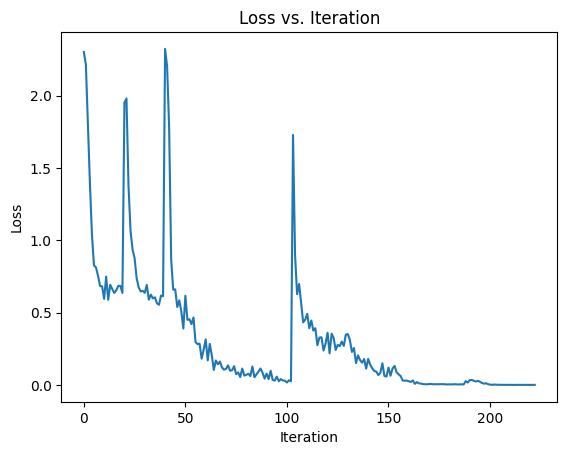

In [221]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()

In [222]:
# 7. Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation during evaluation
    for images, labels in valid_loader: # Use train_loader or a separate test_loader for evaluation
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print('Accuracy of the model on the test images: {} %'.format(accuracy))

# 8. Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# 9. Class-wise Accuracy (Optional)
class_correct = np.zeros(10)  # 10 classes (0-9)
class_total = np.zeros(10)

for i in range(len(all_labels)):
    label = all_labels[i]
    prediction = all_predictions[i]
    if label == prediction:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(10):
    if class_total[i] > 0: # Avoid division by zero
        class_accuracy = 100 * class_correct[i] / class_total[i]
        print(f"Accuracy of class {i}: {class_accuracy:.2f}%")
    else:
      print(f"No samples for class {i} in the test set")

Accuracy of the model on the test images: 88.32 %
Confusion Matrix:
[[ 923    1    8    2    4    7   18    0   11    6]
 [   3 1100    3    4    3    4    7    2    5    4]
 [   9    5  892   40    8   20   13   14   22    9]
 [   7    2   38  837    1   54    3   18   35   15]
 [   3    5    9    1  885    5   16   20   10   28]
 [   9    1   15   67    5  741   12    7   34    1]
 [  15    4   15    2   12   15  875    1   16    3]
 [   2    6   14   19   24    7    0  913    1   42]
 [  18    1   29   38   12   38   10   15  776   37]
 [   7    7   12   10   19    6    5   32   21  890]]
Accuracy of class 0: 94.18%
Accuracy of class 1: 96.92%
Accuracy of class 2: 86.43%
Accuracy of class 3: 82.87%
Accuracy of class 4: 90.12%
Accuracy of class 5: 83.07%
Accuracy of class 6: 91.34%
Accuracy of class 7: 88.81%
Accuracy of class 8: 79.67%
Accuracy of class 9: 88.21%
